Medium post: https://medium.com/@gabogarza/exoplanet-hunting-with-machine-learning-and-kepler-data-recall-100-155e1ddeaa95

Github repo: https://github.com/gabrielgarza/exoplanet-deep-learning

In [1]:
path_to_data = '/home/menegattig/Downloads'

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC, NuSVC
from scipy import ndimage, fft
from sklearn.preprocessing import normalize
import os
root_dir = f"{path_to_data}/data_injected"

print(os.listdir(root_dir))


['exoTest.csv', 'exoTrain.csv']


In [3]:
## Data Preprocessor

In [4]:
import pandas as pd
import numpy as np
from scipy import ndimage, fft
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler

class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        # Apply fourier transform
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform,axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform,axis=1)

            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x):
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x):
                df_dev_x_build[ii] = x
            
            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)


            # Keep first half of data as it is symmetrical after previous steps
            df_train_x = df_train_x.iloc[:,:(df_train_x.shape[1]//2)].values
            df_dev_x = df_dev_x.iloc[:,:(df_dev_x.shape[1]//2)].values

        # Normalize
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x))
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)


        # Gaussian filter to smooth out data
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        if self.standardize:
            # Standardize X data
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x


### Load datasets

In [5]:
train_dataset_path = os.path.join(root_dir, "./exoTrain.csv")
dev_dataset_path = os.path.join(root_dir, "./exoTest.csv")

print("Loading datasets...")
df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")
print("Loaded datasets!")

# Generate X and Y dataframe sets
df_train_x = df_train.drop('LABEL', axis=1)
df_dev_x = df_dev.drop('LABEL', axis=1)
df_train_y = df_train.LABEL
df_dev_y = df_dev.LABEL
df_train

Loading datasets...


Loaded datasets!


,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2.0,93.850000,83.810000,20.100000,-26.980000,-39.56000,-124.710000,-135.180000,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2.0,-38.850389,-33.789154,-58.496531,-40.046242,-79.26802,-72.774017,-86.544612,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2.0,532.640000,535.920000,513.730000,496.920000,456.45000,466.000000,464.500000,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2.0,326.520000,347.390000,302.350000,298.130000,317.74000,312.700000,322.330000,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2.0,-1107.210000,-1112.590000,-1118.950000,-1095.100000,-1057.55000,-1034.480000,-998.340000,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1.0,-91.910000,-92.970000,-78.760000,-97.330000,-68.00000,-68.240000,-75.480000,-49.25,-30.92,...,139.95,147.26,156.95,155.64,156.36,151.75,-24.45,-17.00,3.23,19.28
5083,2.0,989.750000,891.010000,908.530000,851.830000,755.11000,615.780000,595.770000,458.87,492.84,...,-26.50,-4.84,-76.30,-37.84,-153.83,-136.16,38.03,100.28,-45.64,35.58
5084,2.0,273.390000,278.000000,261.730000,236.990000,280.73000,264.900000,252.920000,254.88,237.60,...,-26.82,-53.89,-48.71,30.99,15.96,-3.47,65.73,88.42,79.07,79.43
5085,1.0,3.820000,2.090000,-3.290000,-2.880000,1.66000,-0.750000,3.850000,-0.03,3.28,...,10.86,-3.23,-5.10,-4.61,-9.82,-1.50,-4.65,-14.55,-6.41,-2.55


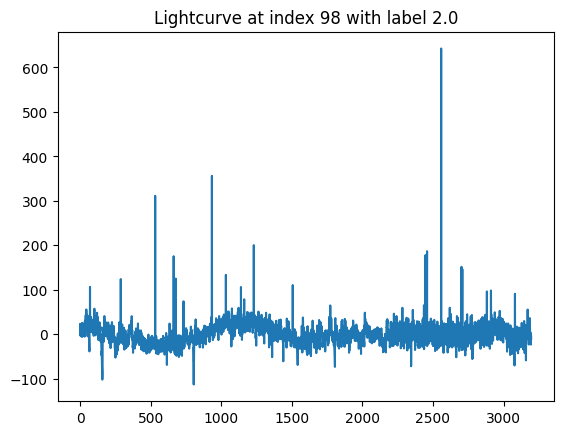

In [6]:
data = df_train_x.to_numpy()
ii = 0
while ii < len(data):
    index = np.random.randint(0, len(data))
    label = df_train_y[index]
    if label == 2.0:
        plt.figure()
        plt.plot(range(len(data[index, :])), data[index, :])
        plt.title(f"Lightcurve at index {index} with label {label}")
        break
    ii += 1

### Process data and create numpy matrices

In [7]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [8]:
# Process dataset
LFP = LightFluxProcessor(
    fourier=True,
    normalize=True,
    gaussian=True,
    standardize=True)
df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

# display(df_train_x)


# Rejoin X and Y
df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

# Load X and Y numpy arrays
X_train, Y_train = np_X_Y_from_df(df_train_processed)
X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!


### Describe datasets

In [9]:
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[1] # n_y : output size
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1


## Build Model, Train, and Predict

In [10]:
model = LinearSVC()


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm.ravel())

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...
Finished Training!
 
 
Train Set Error 0.4187143699626499
Dev Set Error 0.4614035087719298
------------
Precision - Train Set 0.5889078083191438
Precision - Dev Set 0.5557894736842105
------------
Recall - Train Set 0.846207619713387
Recall - Dev Set 0.8354430379746836
------------
Confusion Matrix - Train Set
[[ 536 1690]
 [ 440 2421]]
Confusion Matrix - Dev Set
[[ 43 211]
 [ 52 264]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       0.55      0.24      0.33      2226
        True       0.59      0.85      0.69      2861

    accuracy                           0.58      5087
   macro avg       0.57      0.54      0.51      5087
weighted avg       0.57      0.58      0.54      5087

classification_report_dev
              precision    recall  f1-score   support

       False       0.45      0.17      0.25       254
        True       0.56      0.84      0.67       316

    accuracy            

In [11]:
model = SVC(kernel='poly', degree=4, C=1.0)


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm.ravel())

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...


Finished Training!
 
 
Train Set Error 0.4287399252997838
Dev Set Error 0.45964912280701753
------------
Precision - Train Set 0.5687980574666127
Precision - Dev Set 0.5597345132743363
------------
Recall - Train Set 0.9825235931492485
Recall - Dev Set 0.8006329113924051
------------
Confusion Matrix - Train Set
[[  95 2131]
 [  50 2811]]
Confusion Matrix - Dev Set
[[ 55 199]
 [ 63 253]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       0.66      0.04      0.08      2226
        True       0.57      0.98      0.72      2861

    accuracy                           0.57      5087
   macro avg       0.61      0.51      0.40      5087
weighted avg       0.61      0.57      0.44      5087

classification_report_dev
              precision    recall  f1-score   support

       False       0.47      0.22      0.30       254
        True       0.56      0.80      0.66       316

    accuracy                      

In [12]:
model = model = SVC(kernel='rbf', C=1.0)


X_train_sm, Y_train_sm = X_train, Y_train

# Train
print("Training...")
model.fit(X_train_sm, Y_train_sm.ravel())

train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
print("Finished Training!")
# Metrics
train_outputs = model.predict(X_train_sm)
dev_outputs = model.predict(X_dev)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train_sm, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train_sm, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train_sm, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)
classification_report_train = classification_report(Y_train_sm, train_outputs)
classification_report_dev = classification_report(Y_dev, dev_outputs)

print(" ")
print(" ")
print("Train Set Error", 1.0 - accuracy_train)
print("Dev Set Error", 1.0 - accuracy_dev)
print("------------")
print("Precision - Train Set", precision_train)
print("Precision - Dev Set", precision_dev)
print("------------")
print("Recall - Train Set", recall_train)
print("Recall - Dev Set", recall_dev)
print("------------")
print("Confusion Matrix - Train Set")
print(confusion_matrix_train)
print("Confusion Matrix - Dev Set")
print(confusion_matrix_dev)
print("------------")
print(" ")
print(" ")
print("------------")
print("classification_report_train")
print(classification_report_train)
print("classification_report_dev")
print(classification_report_dev)

Training...
Finished Training!
 
 
Train Set Error 0.4330646746609004
Dev Set Error 0.44561403508771935
------------
Precision - Train Set 0.5653296266878475
Precision - Dev Set 0.5543859649122806
------------
Recall - Train Set 0.9951066060817896
Recall - Dev Set 1.0
------------
Confusion Matrix - Train Set
[[  37 2189]
 [  14 2847]]
Confusion Matrix - Dev Set
[[  0 254]
 [  0 316]]
------------
 
 
------------
classification_report_train
              precision    recall  f1-score   support

       False       0.73      0.02      0.03      2226
        True       0.57      1.00      0.72      2861

    accuracy                           0.57      5087
   macro avg       0.65      0.51      0.38      5087
weighted avg       0.64      0.57      0.42      5087

classification_report_dev
              precision    recall  f1-score   support

       False       0.00      0.00      0.00       254
        True       0.55      1.00      0.71       316

    accuracy                         

/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/menegattig/.pyenv/versions/3.10.15/envs/comp_astro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100, 1000], 'degree': [4]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000], 'gamma': ['scale', 'auto']}
]

grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, scoring='accuracy', cv=2, verbose=3)
grid_search.fit(X_train_sm, Y_train_sm.ravel())

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest model and best parameters:", best_model, best_params)

train_predictions = best_model.predict(X_train_sm)
dev_predictions = best_model.predict(X_dev)

cm = confusion_matrix(Y_dev, dev_predictions)


#pandas table
results = pd.DataFrame(grid_search.cv_results_)[
    ['param_kernel', 'param_C', 'param_degree', 'param_gamma', 'mean_test_score', 'rank_test_score']
]
results = results.sort_values(by='rank_test_score')
display(results)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END ..............C=0.1, kernel=linear;, score=0.528 total time=  16.6s
[CV 2/2] END ..............C=0.1, kernel=linear;, score=0.562 total time=  19.6s
[CV 1/2] END ................C=1, kernel=linear;, score=0.523 total time=  34.0s
[CV 2/2] END ................C=1, kernel=linear;, score=0.530 total time=  32.7s
[CV 1/2] END ...............C=10, kernel=linear;, score=0.517 total time= 4.0min
[CV 2/2] END ...............C=10, kernel=linear;, score=0.521 total time= 6.6min
[CV 1/2] END ......C=0.1, degree=4, kernel=poly;, score=0.559 total time=  34.4s
[CV 2/2] END ......C=0.1, degree=4, kernel=poly;, score=0.561 total time=  34.5s
[CV 1/2] END ........C=1, degree=4, kernel=poly;, score=0.544 total time=  34.9s
[CV 2/2] END ........C=1, degree=4, kernel=poly;, score=0.551 total time=  34.9s
[CV 1/2] END .......C=10, degree=4, kernel=poly;, score=0.541 total time=  35.4s
[CV 2/2] END .......C=10, degree=4, kernel=poly;

,param_kernel,param_C,param_degree,param_gamma,mean_test_score,rank_test_score
8,rbf,0.1,NaN,scale,0.562414,1
9,rbf,0.1,NaN,auto,0.562414,1
3,poly,0.1,4.0,NaN,0.560055,3
11,rbf,1.0,NaN,auto,0.559662,4
10,rbf,1.0,NaN,scale,0.559269,5
4,poly,1.0,4.0,NaN,0.547671,6
0,linear,0.1,NaN,NaN,0.544529,7
5,poly,10.0,4.0,NaN,0.539807,8
1,linear,1.0,NaN,NaN,0.526441,9
6,poly,100.0,4.0,NaN,0.519363,10
